In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries 

import time
import numpy as np
import pandas as pd
import os
import pickle as pkl
from matplotlib import pyplot as plt
from collections import defaultdict
import nltk
import re
import json
import csv
import seaborn as sns
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize

from collections import Counter

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from keras.models import load_model

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten, Lambda
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model, load_model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers, regularizers, optimizers
from keras.callbacks import History, CSVLogger

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, auc
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#load movie dataset
movie_meta = pd.read_csv("/content/drive/MyDrive/DeepLearning/Project/MovieSummaries/movie.metadata.tsv", sep = '\t', header = None)
movie_meta.head(2)



,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"


In [ ]:
# rename columns
movie_meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]
#movie_meta.head(2)
#print(movie_meta[movie_meta['genre'].str.contains("{}")])
x = movie_meta[movie_meta['genre'].str.contains("{}")]
#print(x.index)


In [ ]:
#run only once
movie_meta = pd.DataFrame(movie_meta, index=set(movie_meta.index).difference(set(x.index))).reset_index()

In [ ]:
movie_meta.head(2)

,index,movie_id,1,movie_name,3,4,5,6,7,genre
0,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"


In [ ]:
#load movie dataset
movie_plot = pd.read_csv("/content/drive/MyDrive/DeepLearning/Project/MovieSummaries/plot_summaries.txt", sep = '\t', header = None)
movie_plot.head()

# rename columns
movie_plot.columns = ["movie_id","plots"]
movie_plot.head(2)

,movie_id,plots
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole..."


In [ ]:
# merge meta with movies
movies = pd.merge(movie_plot, movie_meta[['movie_id', 'movie_name', 'genre']], on = 'movie_id')
movies['genre'].isnull().values.any()
movies.head(2)


,movie_id,plots,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}"


In [ ]:
# extracting all genres later adding it to dataframe as lists
genres = [] # an empty list

# extract genres
for i in movies['genre']: 
  genres.append(list(json.loads(i).values())) 

# add to 'movies' dataframe  
movies['genres'] = genres

# remove samples with 0 genre tags
movies_new = movies[~(movies['genres'].str.len() == 0)]
movies_new.shape, movies.shape

movies = movies.drop(columns= "genre")
movies.head(2)

,movie_id,plots,movie_name,genres
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"[Drama, World cinema]"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]"


In [ ]:
# get all genre tags in a list
all_genres = sum(genres,[])
len(set(all_genres))

363

In [ ]:
count_dict = defaultdict(int)

#Count num of movies per genre
def dict_count(row):
    global count_dict
    for genre in row["genres"]:
        count_dict[genre] += 1

In [ ]:
#RUN ONLY ONCE!!!
count_val_series = movies.apply(lambda row: dict_count(row), axis = 1)

In [ ]:
#Count num of movies per genre
for key,val in count_dict.items():
    print("{:0.2f}% of the movies are {}".format(100*val/len(movies), key))


45.78% of the movies are Drama
12.33% of the movies are World cinema
8.50% of the movies are Action/Adventure
5.60% of the movies are Science Fiction
14.04% of the movies are Action
5.78% of the movies are Musical
2.53% of the movies are Bollywood
0.59% of the movies are Screwball comedy
25.04% of the movies are Comedy
10.23% of the movies are Crime Fiction
0.60% of the movies are Docudrama
0.44% of the movies are Courtroom Drama
15.62% of the movies are Thriller
9.77% of the movies are Horror
1.97% of the movies are Teen
4.96% of the movies are Romantic comedy
0.17% of the movies are Media Satire
0.22% of the movies are Americana
3.02% of the movies are Comedy-drama
8.93% of the movies are Black-and-white
15.95% of the movies are Romance Film
7.64% of the movies are Short Film
7.70% of the movies are Family Film
5.84% of the movies are Animation
1.84% of the movies are Parody
3.72% of the movies are War film
0.47% of the movies are Epic
3.16% of the movies are Period piece
2.93% of th

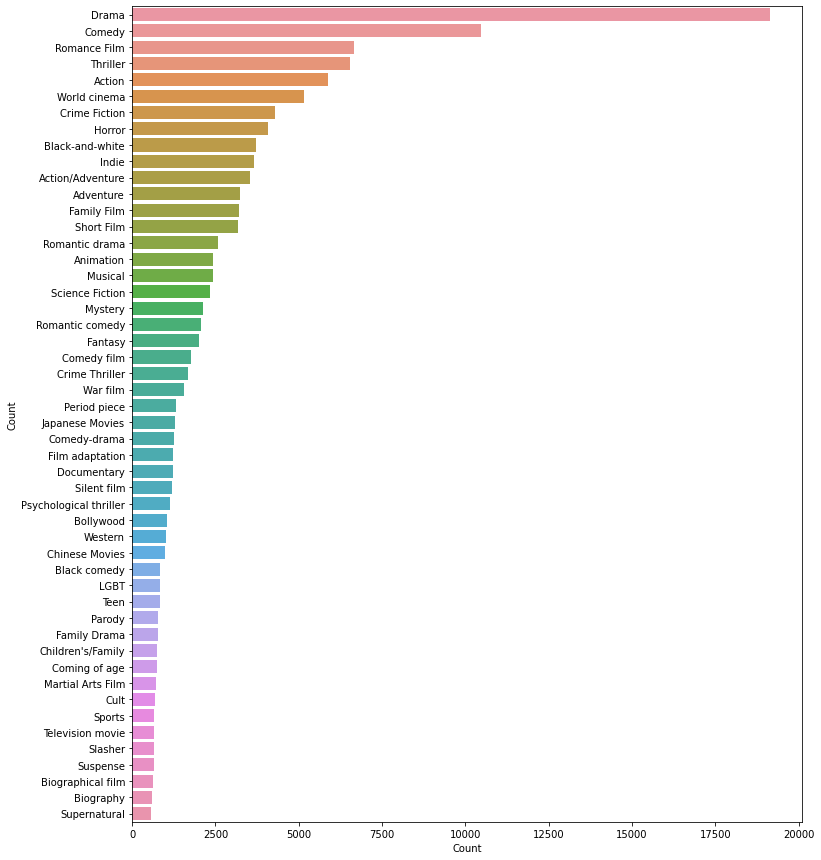

In [ ]:
#creating dictories of genre and occurrence accross the dataset
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

#plotting the distribution
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

# Consolidate Genre Labels

In [ ]:
import operator
sorted(count_dict.items(), key=operator.itemgetter(1))[::-1]

[('Drama', 19134),
 ('Comedy', 10467),
 ('Romance Film', 6666),
 ('Thriller', 6530),
 ('Action', 5868),
 ('World cinema', 5153),
 ('Crime Fiction', 4275),
 ('Horror', 4082),
 ('Black-and-white', 3731),
 ('Indie', 3668),
 ('Action/Adventure', 3553),
 ('Adventure', 3248),
 ('Family Film', 3219),
 ('Short Film', 3192),
 ('Romantic drama', 2572),
 ('Animation', 2441),
 ('Musical', 2414),
 ('Science Fiction', 2339),
 ('Mystery', 2119),
 ('Romantic comedy', 2075),
 ('Fantasy', 2012),
 ('Comedy film', 1778),
 ('Crime Thriller', 1682),
 ('War film', 1556),
 ('Period piece', 1321),
 ('Japanese Movies', 1290),
 ('Comedy-drama', 1261),
 ('Film adaptation', 1225),
 ('Documentary', 1213),
 ('Silent film', 1199),
 ('Psychological thriller', 1138),
 ('Bollywood', 1058),
 ('Western', 1022),
 ('Chinese Movies', 998),
 ('Black comedy', 834),
 ('LGBT', 825),
 ('Teen', 824),
 ('Parody', 767),
 ('Family Drama', 766),
 ("Children's/Family", 759),
 ('Coming of age', 741),
 ('Martial Arts Film', 706),
 ('Cult

In [ ]:
keep = ["Drama", "Comedy", "Romance Film", "Thriller", "Action", "Crime Fiction", "Horror", "Adventure", "Family Film", "Science Fiction"]
lst = list(all_genres.keys())
remove = [x for x in lst if x not in keep ]
len(remove)

353

In [ ]:
def remove_genres(genres):
    return [x for x in genres if x not in remove]

movies["list_genres_consol"] = movies["genres"].apply(lambda row: remove_genres(row))
len(movies)

41793

In [ ]:
movies.head(3)

,movie_id,plots,movie_name,genres,list_genres_consol
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"[Drama, World cinema]",[Drama]
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]","[Science Fiction, Action, Drama]"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"[Musical, Action, Drama, Bollywood]","[Action, Drama]"


In [ ]:
movies = movies.explode("list_genres_consol")
movies = movies.reset_index(drop=True)
movies.head(2)
#movies.tail(10)

,movie_id,plots,movie_name,genres,list_genres_consol
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"[Drama, World cinema]",Drama
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]",Science Fiction


In [ ]:
movies = movies[movies.astype(str)["list_genres_consol"] != "[]"]
len(movies)

71571

In [ ]:
movies.head(3)

,movie_id,plots,movie_name,genres,list_genres_consol
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"[Drama, World cinema]",Drama
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]",Science Fiction
2,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]",Action


In [ ]:
#movies = movies.reset_index(drop=True)

26.73% of the movies are Drama
3.27% of the movies are Science Fiction
8.20% of the movies are Action
14.62% of the movies are Comedy
5.97% of the movies are Crime Fiction
9.12% of the movies are Thriller
5.70% of the movies are Horror
9.31% of the movies are Romance Film
4.50% of the movies are Family Film
4.54% of the movies are Adventure


[Text(0, 0, 'Drama'),
 Text(0, 0, 'Science Fiction'),
 Text(0, 0, 'Action'),
 Text(0, 0, 'Comedy'),
 Text(0, 0, 'Crime Fiction'),
 Text(0, 0, 'Thriller'),
 Text(0, 0, 'Horror'),
 Text(0, 0, 'Romance Film'),
 Text(0, 0, 'Family Film'),
 Text(0, 0, 'Adventure')]

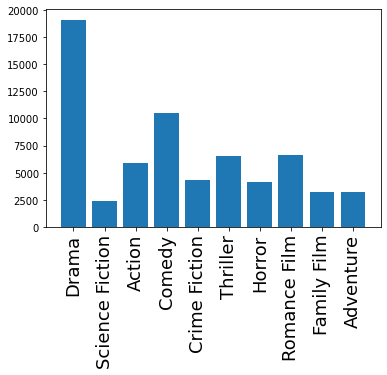

In [ ]:
for key in remove:
    if key in count_dict:
        del count_dict[key]

for key,val in count_dict.items():
    print("{:0.2f}% of the movies are {}".format(100*val/len(movies), key))

fig, ax = plt.subplots(1,1) 
ax.bar(range(len(count_dict.keys())), list(count_dict.values()))
ax.set_xticks(range(len(count_dict.keys())))
ax.set_xticklabels(list(count_dict.keys()), rotation='vertical', fontsize=18)

In [ ]:
movies.head()

,movie_id,plots,movie_name,genres,list_genres_consol
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"[Drama, World cinema]",Drama
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]",Science Fiction
2,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]",Action
3,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]",Drama
4,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"[Musical, Action, Drama, Bollywood]",Action


In [ ]:
#copying movies 
trail1= movies
trail1.head(2) 


,movie_id,plots,movie_name,genres,list_genres_consol
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"[Drama, World cinema]",Drama
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]",Science Fiction


In [ ]:
del trail1['movie_id']
del trail1['genres']

In [ ]:
trail1.columns = ["plots", "movie_name", "genres"]
trail1.head(4) 

,plots,movie_name,genres
0,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,Drama
1,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,Science Fiction
2,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,Action
3,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,Drama


In [ ]:
trail2 = trail1
trail2.head()

,plots,movie_name,genres
0,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,Drama
1,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,World cinema
2,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,Action/Adventure
3,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,Science Fiction
4,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,Action


# Preprocessing the  data

In [ ]:
#Lemmetizing Function (Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, 
#normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma)
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def nltk2wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return wordnet.NOUN

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#Tokenize w/lemmetization AFTER removing stopwords 
#https://machinelearningmastery.com/clean-text-machine-learning-python/
def tokenize(plot, stop_words, lemmatize = False):
    
    def re_sub(pattern, replace):
        return re.sub(pattern, replace, plot)
    
    plot = plot.lower() #lowercase
    plot = re_sub(r"[-+]?[.\d]*[\d]+[:,/.\d]*", "DG") #generic tag for numbers
    plot = re_sub(r"([!?.]){2,}", r"\1") #Convert multiple punctuations to the last punctuation mark
    plot = plot.replace('-',' ') #separating hyphenated words
    plot = plot.replace('_','') #remove underscores
    plot = re_sub(r'(?<!\w)([a-zA-Z])\.', r'\1') #remove periods from abbreviations
    plot = re_sub('[^\w\s\.\?\!\']','') #remove punctuation besides sentence completers and apostrophes
    sentences = nltk.sent_tokenize(plot)
    words = list(map(nltk.word_tokenize, sentences))
    words = [[x for x in w if not x in stop_words] for w in words]

    if lemmatize:
        output_lem = [nltk.pos_tag(w) for w in words]
        return [[lemmatizer.lemmatize(x[0], pos = nltk2wn_tag(x[1])) for x in w] for w in output_lem]
    else:
        return words

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
stop = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
start = time.time()
trail1['tokenized_words'] = trail1.apply(lambda row: tokenize(row['plots'], stop, lemmatize = True), axis=1)
end = time.time()
print("Total Time to tokenize plots:", end - start, "seconds")

Total Time to tokenize plots: 1122.765466928482 seconds


In [ ]:
trail1['flattened_tokens'] = trail1.apply(lambda l: [item for sublist in l['tokenized_words'] for item in sublist], axis=1)

In [ ]:
trail1.head()

,plots,movie_name,genres,tokenized_words,flattened_tokens
0,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,Drama,"[[shlykov, hard, work, taxi, driver, lyosha, saxophonist, develop, bizarre, love, hate, relationship, despite, prejudice, realize, n't, different, .]]","[shlykov, hard, work, taxi, driver, lyosha, saxophonist, develop, bizarre, love, hate, relationship, despite, prejudice, realize, n't, different, .]"
1,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,Science Fiction,"[[nation, panem, consist, wealthy, capitol, twelve, poor, district, .], [punishment, past, rebellion, district, must, provide, boy, girl, age, DG, DG, select, lottery, annual, hunger, game, .], [tribute, must, fight, death, arena, sole, survivor, reward, fame, wealth, .], [first, reap, DG, year,...","[nation, panem, consist, wealthy, capitol, twelve, poor, district, ., punishment, past, rebellion, district, must, provide, boy, girl, age, DG, DG, select, lottery, annual, hunger, game, ., tribute, must, fight, death, arena, sole, survivor, reward, fame, wealth, ., first, reap, DG, year, old, p..."
2,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,Action,"[[nation, panem, consist, wealthy, capitol, twelve, poor, district, .], [punishment, past, rebellion, district, must, provide, boy, girl, age, DG, DG, select, lottery, annual, hunger, game, .], [tribute, must, fight, death, arena, sole, survivor, reward, fame, wealth, .], [first, reap, DG, year,...","[nation, panem, consist, wealthy, capitol, twelve, poor, district, ., punishment, past, rebellion, district, must, provide, boy, girl, age, DG, DG, select, lottery, annual, hunger, game, ., tribute, must, fight, death, arena, sole, survivor, reward, fame, wealth, ., first, reap, DG, year, old, p..."
3,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,Drama,"[[nation, panem, consist, wealthy, capitol, twelve, poor, district, .], [punishment, past, rebellion, district, must, provide, boy, girl, age, DG, DG, select, lottery, annual, hunger, game, .], [tribute, must, fight, death, arena, sole, survivor, reward, fame, wealth, .], [first, reap, DG, year,...","[nation, panem, consist, wealthy, capitol, twelve, poor, district, ., punishment, past, rebellion, district, must, provide, boy, girl, age, DG, DG, select, lottery, annual, hunger, game, ., tribute, must, fight, death, arena, sole, survivor, reward, fame, wealth, ., first, reap, DG, year, old, p..."
4,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,Action,"[[poovalli, induchoodan, sentence, six, year, prison, life, murder, classmate, .], [induchoodan, son, justice, maranchery, karunakara, menon, frame, case, manapally, madhavan, nambiar, crony, dysp, sankaranarayanan, take, revenge, idealist, judge, menon, earlier, give, jail, sentence, manapally,...","[poovalli, induchoo

In [ ]:
type(trail1["movie_name"])

pandas.core.series.Series

In [ ]:
#Binarize labels
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(trail1["genres"])
trail1["binarized_labels"] = labels.tolist()

y = mlb.transform(trail1["genres"])


TypeError: ignored

In [ ]:
mlb.classes_

array(['Action', 'Adventure', 'Comedy', 'Crime Fiction', 'Drama',
       'Family Film', 'Horror', 'Romance Film', 'Science Fiction',
       'Thriller'], dtype=object)

In [ ]:
labels.shape

(36050, 10)

In [ ]:
#Pickle Data
trail1.to_pickle("./trail1.pkl")

In [ ]:
trail1 = pd.read_pickle("./trail1.pkl")
trail1.head(2)

,plots,movie_name,genres,tokenized_words,flattened_tokens,binarized_labels
0,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,[Drama],"[[shlykov, hard, work, taxi, driver, lyosha, saxophonist, develop, bizarre, love, hate, relationship, despite, prejudice, realize, n't, different, .]]","[shlykov, hard, work, taxi, driver, lyosha, saxophonist, develop, bizarre, love, hate, relationship, despite, prejudice, realize, n't, different, .]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
1,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Science Fiction, Action, Drama]","[[nation, panem, consist, wealthy, capitol, twelve, poor, district, .], [punishment, past, rebellion, district, must, provide, boy, girl, age, DG, DG, select, lottery, annual, hunger, game, .], [tribute, must, fight, death, arena, sole, survivor, reward, fame, wealth, .], [first, reap, DG, year,...","[nation, panem, consist, wealthy, capitol, twelve, poor, district, ., punishment, past, rebellion, district, must, provide, boy, girl, age, DG, DG, select, lottery, annual, hunger, game, ., tribute, must, fight, death, arena, sole, survivor, reward, fame, wealth, ., first, reap, DG, year, old, p...","[1, 0, 0, 0, 1, 0, 0, 0, 1, 0]"


#Token Analysis
Iterate over tokenized words and create dictionaries that keep track of number of tokens, length of sentences, and sentences per plot summary

In [ ]:
word_dict = {}
sent_per_summary_dict = {}
word_per_sent_dict = {}
rows = len(trail1['tokenized_words'])
print(rows)#number of plot summaries
for i in range(len(trail1['tokenized_words'])):
    length = len(trail1['tokenized_words'][i])
    if length in sent_per_summary_dict:
        sent_per_summary_dict[length] += 1
    else:
        sent_per_summary_dict[length] = 1
    for j in range(length):
        word_count = len(trail1['tokenized_words'][i][j])
        if word_count in word_per_sent_dict:
            word_per_sent_dict[word_count] += 1
        else:
            word_per_sent_dict[word_count] = 1
        for word in trail1['tokenized_words'][i][j]:
            if word in word_dict:
                word_dict[word] += 1
            else:
                word_dict[word] = 1

36050


In [ ]:

print(len(word_dict.keys())) #should be number of unique words
print(sum(word_dict.values())) #should be total number of words

131861
7172308


In [ ]:
count = 0
twoOrOne = 0
for value in word_dict.values():
    if value == 1:
        count +=1
    if value <3:
        twoOrOne +=1
print(len(word_dict.keys()) - count) # words that appear more than once
print(len(word_dict.keys()) - twoOrOne) # words that appear more than twice

76241
60642


In [ ]:
print(len(word_per_sent_dict.keys())) #should be number of unique sentence lengths
print(sum(word_per_sent_dict.values())) #should be number of sentences in all plots
print(max(word_per_sent_dict.keys())) #should be largest sentence length
total = 0
weight_sum = 0
for key, value in word_per_sent_dict.items():
    total += value
    weight_sum += key*value
print(weight_sum/total) #should be average sentence length
#print(word_per_sent_dict)

111
587257
273
12.213235431846705


In [ ]:
print(len(sent_per_summary_dict.keys())) #should be number of unique sentence lengths per summary
print(max(sent_per_summary_dict.keys())) #should be highest amount of sentences per summary
total = 0
weight_sum = 0
for key, value in sent_per_summary_dict.items():
    total += value
    weight_sum += key*value
print(weight_sum/total) #should be average sentence count per summary
#print(sent_per_summary_dict)

152
321
16.290069348127602


#Load GloVe Word Embeddings

In [ ]:
#Load GloVe Word Embeddings
#compute an index mapping words to known embeddings, by parsing the data dump of pre-trained embeddings
embeddings_index = {}
GLOVE_DIR = '/content/drive/MyDrive/deep LEarning Project_/'
f = open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
#create average word vector. This will later be used in place of unknown words
with open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'), 'r') as f:
    for i, line in enumerate(f):
        pass
n_vec = i + 1
hidden_dim = len(line.split(' ')) - 1

vecs = np.zeros((n_vec, hidden_dim), dtype=np.float32)

with open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'), 'r') as f:
    for i, line in enumerate(f):
        vecs[i] = np.array([float(n) for n in line.split(' ')[1:]], dtype=np.float32)

average_vec = np.mean(vecs, axis=0)
#print(average_vec)

#Keras Modeling
Based on the above token analysis, we set the following hyperparameters at these initial values

In [ ]:
MAX_SENT_LENGTH = 100 #Gets ~80% of sentences
MAX_SENTS = 100 #Gets ~80% of summaries
MAX_NB_WORDS = 20000 #Eliminates words seen two or fewer times
EMBEDDING_DIM = 300

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token= True)
tokenizer.fit_on_texts(trail1['flattened_tokens'])

In [ ]:
data = np.zeros((len(trail1), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
doc_lst = []

# keep the MAX_NB_WORDS most frequent words and replace the rest with 'UNK'
# truncate to the first MAX_SENTS sentences per doc and MAX_SENT_LENGTH words per sentence

for summary_num, row in trail1.iterrows():
    for sent_num, sent in enumerate(row['tokenized_words']):
        if sent_num < MAX_SENTS:
            word_num = 0
            words_in_sent = []
            for _, word in enumerate(sent):
                if word_num < MAX_SENT_LENGTH: 
                    try:
                        if (word in tokenizer.word_index) and (tokenizer.word_index[word] < MAX_NB_WORDS):
                            data[summary_num, sent_num, word_num] = tokenizer.word_index[word]
                            words_in_sent.append(word)
                        else:
                            data[summary_num, sent_num, word_num] = MAX_NB_WORDS
                            words_in_sent.append('UNK')
                        word_num = word_num + 1
                    except IndexError:
                        print(summary_num)
                        print(sent_num)
                        print(word_num)
                        print(row)
                        print(word)
            doc_lst.append(words_in_sent)

In [ ]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

print('Shape of data tensor:', data.shape)

Total 131860 unique tokens.
Shape of data tensor: (36050, 100, 100)


In [ ]:
#leverage our embedding_index dictionary and our word_index to compute our embedding matrix
embedding_matrix = np.zeros((MAX_NB_WORDS+1, EMBEDDING_DIM))
count = 0
unknown =0
added =0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    # words not found in embedding index will be all-zeros.
    if embedding_vector is not None and i < MAX_NB_WORDS:
        embedding_matrix[i] = embedding_vector
        added+=1
    elif i == MAX_NB_WORDS:
        # index MAX_NB_WORDS in data corresponds to 'UNK'
        embedding_matrix[i] = average_vec #use average vector for unknown
        unknown+=1
    else:
        count +=1
print(added) #of the MAX_NB_WORDS most frequent tokens in our corpus, this many have GloVe embeddings
print(unknown)
print(count)

19601
1
112258


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')

Total absent words are 51764 which is 39.26 % of total words


In [ ]:
#load this embedding matrix into an Embedding layer.
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

embedding_layer = Embedding(MAX_NB_WORDS + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            embeddings_regularizer=l2_reg,
                            mask_zero = True, #determines whether masking is performed, i.e. whether the layers ignore the padded zeros in shorter documents
                            trainable=False) #prevent weights from being updated during training

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix], 
                            input_length=MAX_SENT_LENGTH, 
                            trainable=False)

In [ ]:
#https://github.com/Hsankesara/DeepResearch/blob/master/Hierarchical_Attention_Network/attention_with_context.py
#https://medium.com/analytics-vidhya/hierarchical-attention-networks-d220318cf87e
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed
from keras import backend as K
from keras import optimizers
from keras.models import Model
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

# HAN model 


In [ ]:
# Words level attention model
word_input = Input(shape=(MAX_SENT_LENGTH,), dtype='float32')
word_sequences = embedding_layer(word_input)
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(word_sequences)
word_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_dense)
wordEncoder = Model(word_input, word_att)

# Sentence level attention model
sent_input = Input(shape=(MAX_SENTS, MAX_SENT_LENGTH), dtype='float32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(sent_encoder)
sent_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(sent_lstm)
sent_att = Dropout(0.5)(AttentionWithContext()(sent_dense))
preds = Dense(10, activation='sigmoid')(sent_att)
model = Model(sent_input, preds)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',  metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100, 100)]        0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 100, 200)          40200100  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 300)          421200    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 100, 200)          60200     
_________________________________________________________________
attention_with_context_5 (At (None, 200)               40400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)              

#Create train/test split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.10, random_state=42)

#Training the model

In [ ]:
fname = 'han_food'
history = History()
csv_logger = CSVLogger('./{0}_{1}.log'.format(fname, REG_PARAM), separator=',', append=True)

In [ ]:
BATCH_SIZE = 64
NUM_EPOCHS = 30

In [ ]:
print(x_train.shape)
print(y_train.shape)

(32445, 100, 100)
(32445, 10)


In [ ]:
t1 = time.time()

model.fit(x_train, y_train,steps_per_epoch=250, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=False, 
          callbacks=[history, csv_logger])

t2 = time.time()

Epoch 1/30
250/250 [==============================] - 102s 408ms/step - loss: 3.3492 - accuracy: 0.3992
Epoch 2/30
250/250 [==============================] - 102s 409ms/step - loss: 2.9867 - accuracy: 0.4623
Epoch 3/30
250/250 [==============================] - 102s 409ms/step - loss: 2.8877 - accuracy: 0.4918
Epoch 4/30
250/250 [==============================] - 102s 409ms/step - loss: 2.8546 - accuracy: 0.4882
Epoch 5/30
250/250 [==============================] - 102s 409ms/step - loss: 2.7840 - accuracy: 0.5052
Epoch 6/30
250/250 [==============================] - 102s 409ms/step - loss: 2.7556 - accuracy: 0.5051
Epoch 7/30
250/250 [==============================] - 104s 417ms/step - loss: 2.7046 - accuracy: 0.5170
Epoch 8/30
250/250 [==============================] - 104s 417ms/step - loss: 2.6630 - accuracy: 0.5133
Epoch 9/30
250/250 [==============================] - 104s 417ms/step - loss: 2.6105 - accuracy: 0.5295
Epoch 10/30
250/250 [==============================] - 104s 414m

# Saving the model 

# Prediction


In [ ]:
from pandas import DataFrame
# Actual Genre : Action : ok 
#genre_sample = ["The work of billionaire tech CEO Donovan Chalmers (Willis) is so valuable that he hires mercenaries to protect it, and a terrorist group kidnaps his daughter just to get it"] # Actual Genre : Action

#Actual genre: Romace, Drama : ok
#genre_sample = ["Massimo is a member of the Sicilian Mafia family and Laura is a sales director. She does not expect that on a trip to Sicily trying to save her relationship, Massimo will kidnap her and give her 365 days to fall in love with him."] 

#Actual Genre : Drama : ok
#genre_sample = ["In Chicago 1968, the Democratic Party Convention was met with protests from activists like the moderate Students for a Democratic Society led by Tom Hayden and the militant Yippies led by Abbie Hoffman and Jerry Rubin, which led to violent confrontations with the local authorities. As a result, seven of the accused ringleaders are arraigned on charges like Conspiracy by the hostile Nixon administration, including Bobby Seale of the Black Panthers who was not involved in the incident. What follows is an unfair trial presided by the belligerent Judge Hoffman (No relation) and prosecuted by a reluctant but duty-bound Richard Schultz. As their pro bono lawyers face such odds, Hayden and his fellows are frustrated by the Yippies' outrageous antics undermining their defense in defiance of the system even while Seale is denied a chance to defend himself his way. Along the way, the Chicago 7 clash in their political philosophies even as they learn they need each other in this fight."] 

#Actual Genre : Thriller : ok
genre_sample = ["A secret agent embarks on a dangerous, time-bending mission to prevent the start of World War III."] # Actual Genre : Action

#Actual genre: Action thriller crime : not ok
#genre_sample = ["The Fast and the Furious takes you inside the world of street racing. Dominic Toretto is a gang leader who is accused of hijacking trucks and stealing over a million dollars worth of electronic equipment. The FBI sends LAPD officer Brian O'Conner undercover into Los Angeles' street racing circuit to take down Toretto and his team. As O'Conner becomes part of Toretto's life and gets involved with his sister, Mia, he tries to prove that Toretto is innocent."] 

#Actual genre: Science Fiction : not ok 
#genre_sample =["Deemed insane for claiming that the failed rescue mission in the Philippine waters was doomed because of a seemingly-extinct predator of epic proportions--the prehistoric, Megalodon--Jonas Taylor, the world's greatest deep-sea rescue diver, finds himself in the vast ocean realm of Mariana Trench, five years later. But, as three scientists of an underwater research facility near Shanghai get trapped inside a crippled submersible attacked by an unknown creature, Jonas will need to work fast to redeem himself. Could the disgraced rescuer's theories about the vicious underwater leviathan be true after all?"]

#Actual genre: Crime : not ok
#genre_sample =["After uncovering a massive conspiracy, an embattled NYPD detective joins a citywide manhunt for two young cop killers. As the night unfolds, he soon becomes unsure of who to pursue and who's in pursuit of him. When the search intensifies, authorities decide to take extreme measures by closing all of Manhattan's 21 bridges to prevent the suspects from escaping."]




df = DataFrame(genre_sample,columns=['to_pred'])

labels=['Action', 'Adventure', 'Comedy', 'Crime Fiction', 'Drama',
       'Family Film', 'Horror', 'Romance Film', 'Science Fiction',
       'Thriller']

df['to_pred_tokenized_words'] = df.apply(lambda row: tokenize(row['to_pred'], stop, lemmatize = True), axis=1)
df['to_pred_flattened_tokens'] = df.apply(lambda l: [item for sublist in l['to_pred_tokenized_words'] for item in sublist], axis=1)

MAX_SENT_LENGTH1 = 100 #Gets ~80% of sentences
MAX_SENTS1 = 100 #Gets ~80% of summaries
MAX_NB_WORDS1 = 20000 #Eliminates words seen two or fewer times
EMBEDDING_DIM1 = 300

tokenizer1 = Tokenizer(num_words=MAX_NB_WORDS1)
tokenizer1.fit_on_texts(df['to_pred_flattened_tokens'])

data1 = np.zeros((len(df), MAX_SENTS1, MAX_SENT_LENGTH1), dtype='int32')
doc_lst1 = []

# keep the MAX_NB_WORDS most frequent words and replace the rest with 'UNK'
# truncate to the first MAX_SENTS sentences per doc and MAX_SENT_LENGTH words per sentence

for summary_num, row in df.iterrows():
    for sent_num, sent in enumerate(row['to_pred_tokenized_words']):
        if sent_num < MAX_SENTS1:
            word_num = 0
            words_in_sent = []
            for _, word in enumerate(sent):
                if word_num < MAX_SENT_LENGTH1: 
                    try:
                        if (word in tokenizer1.word_index) and (tokenizer1.word_index[word] < MAX_NB_WORDS1):
                            data1[summary_num, sent_num, word_num] = tokenizer1.word_index[word]
                            words_in_sent.append(word)
                        else:
                            data1[summary_num, sent_num, word_num] = MAX_NB_WORDS1
                            words_in_sent.append('UNK')
                        word_num = word_num + 1
                    except IndexError:
                        print(summary_num)
                        print(sent_num)
                        print(word_num)
                        print(row)
                        print(word)
            doc_lst.append(words_in_sent)

word_index1 = tokenizer1.word_index
print('Total %s unique tokens.' % len(word_index1))
print('Shape of data tensor:', data1.shape)

Total 13 unique tokens.
Shape of data tensor: (1, 100, 100)


In [ ]:
res = model.predict(data1)
res.shape
print(labels[np.argmax(res)])

Thriller


# Movie Suggestion 


In [ ]:
suggestion = trail1
#del suggestion['tokenized_words']
#del suggestion['flattened_tokens']
#del suggestion['binarized_labels']
#del suggestion['plots']
Action,Adventure,Comedy,Crime_Fiction,Drama,Family_Film,Horror,Romance_Film,Science_Fiction,Thriller = [],[],[],[],[],[],[],[],[],[]
suggestion

for i in range(len(suggestion['genres'])):
  temp = suggestion['genres'][i]
  for j in temp:
    if j == 'Action':
      Action.append(suggestion['movie_name'][i])
    elif j == 'Adventure':
      Adventure.append(suggestion['movie_name'][i])
    elif j == 'Comedy':
      Comedy.append(suggestion['movie_name'][i])
    elif j == 'Crime Fiction':
      Crime_Fiction.append(suggestion['movie_name'][i])
    elif j == 'Drama':
      Drama.append(suggestion['movie_name'][i])
    elif j == 'Family Film':
      Family_Film.append(suggestion['movie_name'][i])
    elif j == 'Horror':
      Horror.append(suggestion['movie_name'][i])
    elif j == 'Romance Film':
      Romance_Film.append(suggestion['movie_name'][i])
    elif j == 'Science Fiction':
      Science_Fiction.append(suggestion['movie_name'][i])
    elif j == 'Thriller':
      Thriller.append(suggestion['movie_name'][i])
print(Action,Adventure,Comedy,Crime_Fiction,Drama,Family_Film,Horror,Romance_Film,Science_Fiction,Thriller)

['The Hunger Games', 'Narasimham', 'End Game', 'Exodus', 'Ashes to Ashes', "Class of '61", 'Samson and Delilah', 'Getting Even', 'River of No Return', 'Red Cliff', 'The Good, the Bad, the Weird', 'Jaws: The Revenge', 'Sagar alias Jackie', 'The Man from Monterey', 'Treed Murray', 'The Bloody Fists', 'Champion', 'Day Watch', 'Until Death', 'The Black Corsair', 'Bug Buster', 'Maneater', 'Maha Chor', 'Always Outnumbered', 'The Secret Man', 'Enemies Among Us', 'Agent Vinod', 'Billa 2', 'Face the Evil', 'The Spell of the Circus', 'Aces: Iron Eagle III', 'Land of the Lost', 'The Mechanical Monsters', 'Ghetto Stories: The Movie', 'Mela', 'Outpost', 'An Eye for an Eye', 'Le Magnifique', 'The Last Witness', 'Big Nothing', 'The In-Laws', 'Gharshana', 'Madurai Veeran', 'Rocky', 'Bring Me the Head of Charlie Brown', 'Next Day Air', 'Merupu Daadi', 'The Cold Light of Day', 'Appleseed', 'Newtonin 3-m Vidhi', 'Farewell to the Duman River', 'Here Comes the Boom', 'Manthri gari Viyyankudu', 'Veer', 'Nev

In [ ]:
grouped = suggestion.groupby('genres', axis='columns')
grouped